In [6]:
# %%  Cell 1 — pick a pair (image + mask) that really has a mask

from pathlib import Path
import pandas as pd

DATA_ROOT = Path("./sts_tooth_data").resolve()
INDEX_CSV = DATA_ROOT / "sts2d_index.csv"

# 1) load index
df = pd.read_csv(INDEX_CSV)

# 2) compute how many image-like and mask-like files each pair_id has
pair_stats = (
    df.groupby(["pair_id", "is_mask"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: "num_image_like", True: "num_mask_like"})
)

# 3) keep only those pair_ids that have at least 1 image and 1 mask
valid_pair_ids = pair_stats[
    (pair_stats.get("num_image_like", 0) > 0)
    & (pair_stats.get("num_mask_like", 0) > 0)
].index

print("Number of pairs with BOTH image and mask:", len(valid_pair_ids))

# 4) randomly choose one valid pair_id
sample_pair_id = pd.Series(list(valid_pair_ids)).sample(1, random_state=0).iloc[0]
print("Chosen pair_id:", sample_pair_id)

# 5) get rows for this pair_id
sample_rows = df[df["pair_id"] == sample_pair_id]

img_row = sample_rows[sample_rows["is_mask"] == False].iloc[0]
mask_row = sample_rows[sample_rows["is_mask"] == True].iloc[0]

img_rel      = img_row["rel_path"]      # relative path of image (inside STS-2D-Tooth)
mask_rel     = mask_row["rel_path"]     # relative path of mask  (inside STS-2D-Tooth)
age_group    = img_row["age_group"]     # 'adult' or 'children'
label_status = img_row["label_status"]  # should be 'labeled'

print("img_rel     :", img_rel)
print("mask_rel    :", mask_rel)
print("age_group   :", age_group)
print("label_status:", label_status)


Number of pairs with BOTH image and mask: 900
Chosen pair_id: a_l_493
img_rel     : A-PXI/Labeled/Image/A_L_493.png
mask_rel    : A-PXI/Labeled/Mask/A_L_493.png
age_group   : adult
label_status: labeled


Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_493.png
Mask path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\masks\A_L_493.png


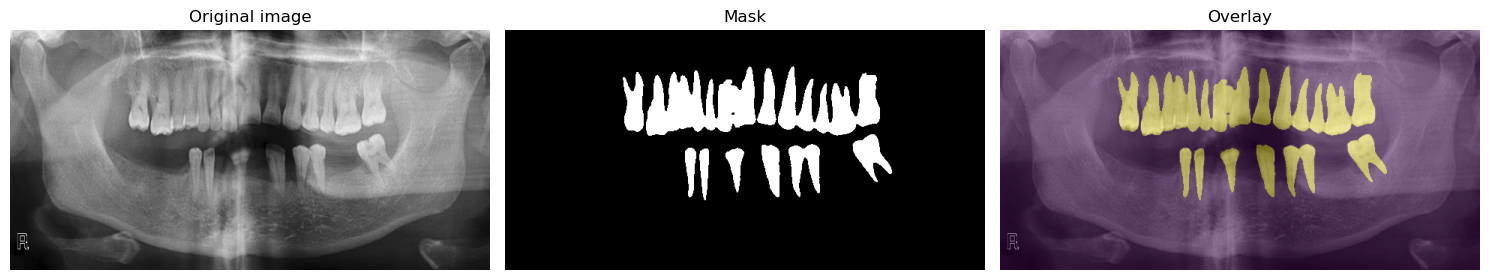

In [7]:
# %%  Cell 2 — visualize image + mask + overlay

from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

DATA_ROOT = Path("./sts_tooth_data").resolve()
PROCESSED_2D_DIR = DATA_ROOT / "processed_2d"

# build absolute paths inside processed_2d
img_path  = PROCESSED_2D_DIR / age_group / label_status / "images" / Path(img_rel).name
mask_path = PROCESSED_2D_DIR / age_group / label_status / "masks"  / Path(mask_rel).name

print("Image path:", img_path)
print("Mask path :", mask_path)

if not img_path.exists():
    raise FileNotFoundError(f"Image not found: {img_path}")
if not mask_path.exists():
    raise FileNotFoundError(f"Mask not found: {mask_path}")

img  = Image.open(img_path).convert("L")
mask = Image.open(mask_path).convert("L")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

axes[2].imshow(img, cmap="gray")
axes[2].imshow(mask, alpha=0.4)
axes[2].set_title("Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Imports and global configuration
from pathlib import Path
import random
import os

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader

# Make plots appear inline (Jupyter)
# (PyCharm / VSCode may ignore this, which is fine)
%matplotlib inline  

# Set some global seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Root directory used in preprocessing.ipynb
DATA_ROOT = Path("./sts_tooth_data").resolve()
PROCESSED_2D_DIR = DATA_ROOT / "processed_2d"
INDEX_CSV = DATA_ROOT / "sts2d_index.csv"

print("DATA_ROOT       :", DATA_ROOT)
print("PROCESSED_2D_DIR:", PROCESSED_2D_DIR)
print("INDEX_CSV       :", INDEX_CSV)

assert INDEX_CSV.exists(), "Index CSV not found. Please run preprocessing.ipynb first."
assert PROCESSED_2D_DIR.exists(), "processed_2d directory not found. Please run preprocessing.ipynb first."


DATA_ROOT       : E:\Data\ToothSeg\sts_tooth_data
PROCESSED_2D_DIR: E:\Data\ToothSeg\sts_tooth_data\processed_2d
INDEX_CSV       : E:\Data\ToothSeg\sts_tooth_data\sts2d_index.csv


In [10]:
# Load index and build image / mask / pair tables

df = pd.read_csv(INDEX_CSV)

print("Full index shape:", df.shape)
print(df.head())

print("\nValue counts — age_group:")
print(df["age_group"].value_counts())

print("\nValue counts — label_status:")
print(df["label_status"].value_counts())

print("\nValue counts — is_mask:")
print(df["is_mask"].value_counts())

# Split into images and masks
df_img = df[df["is_mask"] == False].copy()
df_mask = df[df["is_mask"] == True].copy()

print("\nNumber of image rows:", len(df_img))
print("Number of mask rows :", len(df_mask))

# Build a table of pair_ids that have at least one image and one mask
pair_stats = (
    df.groupby(["pair_id", "is_mask"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: "num_image_like", True: "num_mask_like"})
)

num_pairs_with_both = (pair_stats["num_image_like"] > 0) & (pair_stats["num_mask_like"] > 0)
print("\nNumber of pair_ids with BOTH image and mask:", num_pairs_with_both.sum())

# Build a segmentation dataframe: one row per image that has a mask
df_seg = pd.merge(
    df_img,
    df_mask[["pair_id", "rel_path"]].rename(columns={"rel_path": "mask_rel"}),
    on="pair_id",
    how="inner",
)

print("\nSegmentation dataframe shape:", df_seg.shape)
print(df_seg.head(3))

# For pretraining (Stage 1), we use ALL non-mask images (df_img)
df_pretrain = df_img.copy()
print("\nPretraining dataframe shape (all images, mask images excluded):", df_pretrain.shape)


# %% [markdown]
# ## 2. Helper functions for reading images and masks
# 
# Now we define small utility functions to:
# 
# - Map a row from `df_pretrain` / `df_seg` to an actual image file under `processed_2d`.
# - Load images and masks as NumPy arrays suitable for Albumentations.
# 
# Directory layout under `processed_2d` (from preprocessing):
# 
# ```text
# processed_2d/
#   adult/
#     labeled/
#       images/
#       masks/
#     unlabeled/
#       images/
#   children/
#     labeled/
#       images/
#       masks/
#     unlabeled/
#       images/
#   unknown/ ...
# ```

Full index shape: (4900, 5)
                          rel_path age_group label_status  is_mask  pair_id
0  A-PXI/Labeled/Image/A_L_001.png     adult      labeled    False  a_l_001
1  A-PXI/Labeled/Image/A_L_002.png     adult      labeled    False  a_l_002
2  A-PXI/Labeled/Image/A_L_003.png     adult      labeled    False  a_l_003
3  A-PXI/Labeled/Image/A_L_004.png     adult      labeled    False  a_l_004
4  A-PXI/Labeled/Image/A_L_005.png     adult      labeled    False  a_l_005

Value counts — age_group:
age_group
adult       4350
children     550
Name: count, dtype: int64

Value counts — label_status:
label_status
unlabeled    3100
labeled      1800
Name: count, dtype: int64

Value counts — is_mask:
is_mask
False    4000
True      900
Name: count, dtype: int64

Number of image rows: 4000
Number of mask rows : 900

Number of pair_ids with BOTH image and mask: 900

Segmentation dataframe shape: (900, 6)
                          rel_path age_group label_status  is_mask  pair_id  \
0  A

Example image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_071.png
Example mask path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\masks\A_L_071.png


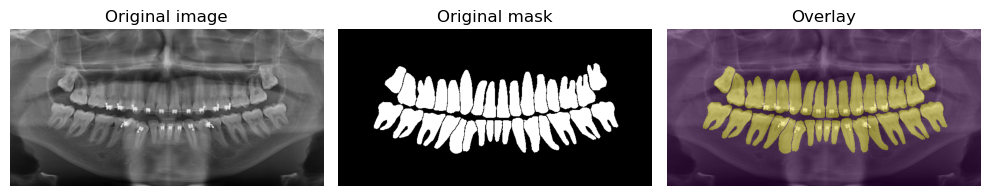

In [11]:
# Path mapping and image loading helpers

def get_image_path_from_row(row: pd.Series) -> Path:
    """
    Build the path to an image file under processed_2d from a DataFrame row.

    For images, we use:
        processed_2d / age_group / label_status / "images" / <filename>

    where <filename> is taken from the original rel_path.
    """
    age_group = row["age_group"] if isinstance(row["age_group"], str) else "unknown"
    label_status = row["label_status"] if isinstance(row["label_status"], str) else "unknown"

    filename = Path(row["rel_path"]).name
    img_path = PROCESSED_2D_DIR / age_group / label_status / "images" / filename
    return img_path


def get_mask_path_from_row(row: pd.Series) -> Path:
    """
    Build the path to a mask file under processed_2d from a segmentation row.

    df_seg has a column 'mask_rel' which stores the original relative path of the mask.
    We again map it to:
        processed_2d / age_group / label_status / "masks" / <mask_filename>
    """
    age_group = row["age_group"] if isinstance(row["age_group"], str) else "unknown"
    label_status = row["label_status"] if isinstance(row["label_status"], str) else "unknown"

    filename = Path(row["mask_rel"]).name
    mask_path = PROCESSED_2D_DIR / age_group / label_status / "masks" / filename
    return mask_path


def load_image_as_array(path: Path) -> np.ndarray:
    """
    Load a grayscale PNG as a NumPy array with shape (H, W).

    We use OpenCV in grayscale mode (0), which returns a 2D array of type uint8.
    """
    if not path.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError(f"Failed to read image: {path}")
    return img


def load_mask_as_array(path: Path) -> np.ndarray:
    """
    Load a segmentation mask as a NumPy array with shape (H, W).

    Masks are usually stored as uint8 (0, 1, 2, ...). We keep them as integers
    because they represent class indices, not intensities.
    """
    if not path.exists():
        raise FileNotFoundError(f"Mask not found: {path}")
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise RuntimeError(f"Failed to read mask: {path}")
    return mask


# Quick sanity check: load and visualize one segmentation pair
example_row = df_seg.sample(1, random_state=SEED).iloc[0]

example_img_path = get_image_path_from_row(example_row)
example_mask_path = get_mask_path_from_row(example_row)

print("Example image path:", example_img_path)
print("Example mask path :", example_mask_path)

example_img = load_image_as_array(example_img_path)
example_mask = load_mask_as_array(example_mask_path)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(example_img, cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(example_mask, cmap="gray")
plt.title("Original mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(example_img, cmap="gray")
plt.imshow(example_mask, alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


# %% [markdown]
# ## 3. Define augmentation configurations
# 
# We will use **Albumentations** for flexible, image-friendly augmentation.
# 
# We define three presets:
# 
# 1. **Segmentation training (`seg_train_transform`)**
#    - Mild to moderate geometric transforms (shift/scale/rotate, crop, flip).
#    - Mild brightness/contrast and noise.
#    - Applied to both image and mask (geometrically consistent).
# 
# 2. **Weak view for pretraining (`ssl_weak_transform`)**
#    - Similar to segmentation but slightly simpler.
#    - Good for general supervised training as well.
# 
# 3. **Strong view for pretraining (`ssl_strong_transform`)**
#    - More aggressive cropping, color/intensity jitter, blur, and cutout.
#    - Used only for Stage 1 self-supervised pretraining.
# 
# **Important medical constraints:**
# 
# - **No vertical flip** (we don't want to swap upper and lower jaws).
# - Only **small rotations** (e.g. ±10–15 degrees).
# - Cropping should not completely remove the dental arches.
# - All geometric transforms must be applied consistently to image and mask.

In [26]:
# Albumentations transform builders

TARGET_HEIGHT = 320
TARGET_WIDTH = 640


def get_segmentation_train_transform() -> A.Compose:
    """
    Augmentation pipeline for supervised segmentation training.

    This transform:
    - Resizes the image to 320 x 640.
    - Applies random horizontal flip.
    - Applies mild Shift/Scale/Rotate.
    - Applies RandomResizedCrop to introduce some cropping variability.
    - Applies mild brightness/contrast changes and Gaussian noise.
    - Finally converts to PyTorch tensors.

    Notes:
    - Geometric transforms are applied to both image and mask.
    - Intensity transforms only affect images.
    """
    return A.Compose(
        [
            # Ensure a consistent resolution
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),

            # Geometric transforms (applied to both image & mask)
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.75,
            ),
            # New API: use size=(H, W)
            A.RandomResizedCrop(
                size=(TARGET_HEIGHT, TARGET_WIDTH),
                scale=(0.8, 1.0),
                ratio=(1.5, 2.5),
                p=0.5,
            ),

            # Intensity transforms (image only)
            A.RandomBrightnessContrast(
                brightness_limit=0.15,
                contrast_limit=0.15,
                p=0.5,
            ),
            # Use default noise parameters (avoid var_limit warnings)
            A.GaussNoise(p=0.3),

            # Normalize to [0,1] then standardize.
            A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),

            # Convert to PyTorch tensors
            ToTensorV2(),
        ]
    )


def get_segmentation_val_transform() -> A.Compose:
    """
    Simple transform for validation / test.

    Only resizes and normalizes, no random augmentation.
    """
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ]
    )


def get_ssl_weak_transform() -> A.Compose:
    """
    Weak augmentation for self-supervised / pretraining.

    Similar to segmentation training, but slightly simpler.
    """
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            A.HorizontalFlip(p=0.5),

            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.7,
            ),

            A.RandomBrightnessContrast(
                brightness_limit=0.2,
                contrast_limit=0.2,
                p=0.5,
            ),
            A.GaussNoise(p=0.3),

            A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ]
    )


def get_ssl_strong_transform() -> A.Compose:
    """
    Strong augmentation for self-supervised / contrastive pretraining.

    - Stronger cropping & color jitter.
    - Additional blur and stronger noise.
    - We no longer use CoarseDropout here.
    """
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),

            A.RandomResizedCrop(
                size=(TARGET_HEIGHT, TARGET_WIDTH),
                scale=(0.5, 1.0),   # more aggressive cropping
                ratio=(1.2, 3.0),
                p=1.0,
            ),

            A.HorizontalFlip(p=0.5),

            A.ShiftScaleRotate(
                shift_limit=0.08,
                scale_limit=0.15,
                rotate_limit=15,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.8,
            ),

            A.RandomBrightnessContrast(
                brightness_limit=0.3,
                contrast_limit=0.3,
                p=0.8,
            ),

            A.GaussianBlur(blur_limit=(3, 7), p=0.3),
            A.GaussNoise(p=0.5),

            A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ]
    )

# %% [markdown]
# ## 3. Albumentations transform builders
# 
# We define 4 transforms:
# 
# 1. `get_segmentation_train_transform()`
# 2. `get_segmentation_val_transform()`
# 3. `get_ssl_weak_transform()`  – weak augmentation for pretraining
# 4. `get_ssl_strong_transform()` – stronger augmentation for pretraining
# 
# Notes:
# - We use the original image size 320 (H) x 640 (W).
# - We do NOT use CoarseDropout here anymore.
# - Masked Image Modeling (MIM) style masking will be handled separately later.


D:\Tool\Anaconda3\envs\dlcv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



=== Example pair ===
Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_071.png
Mask path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\masks\A_L_071.png


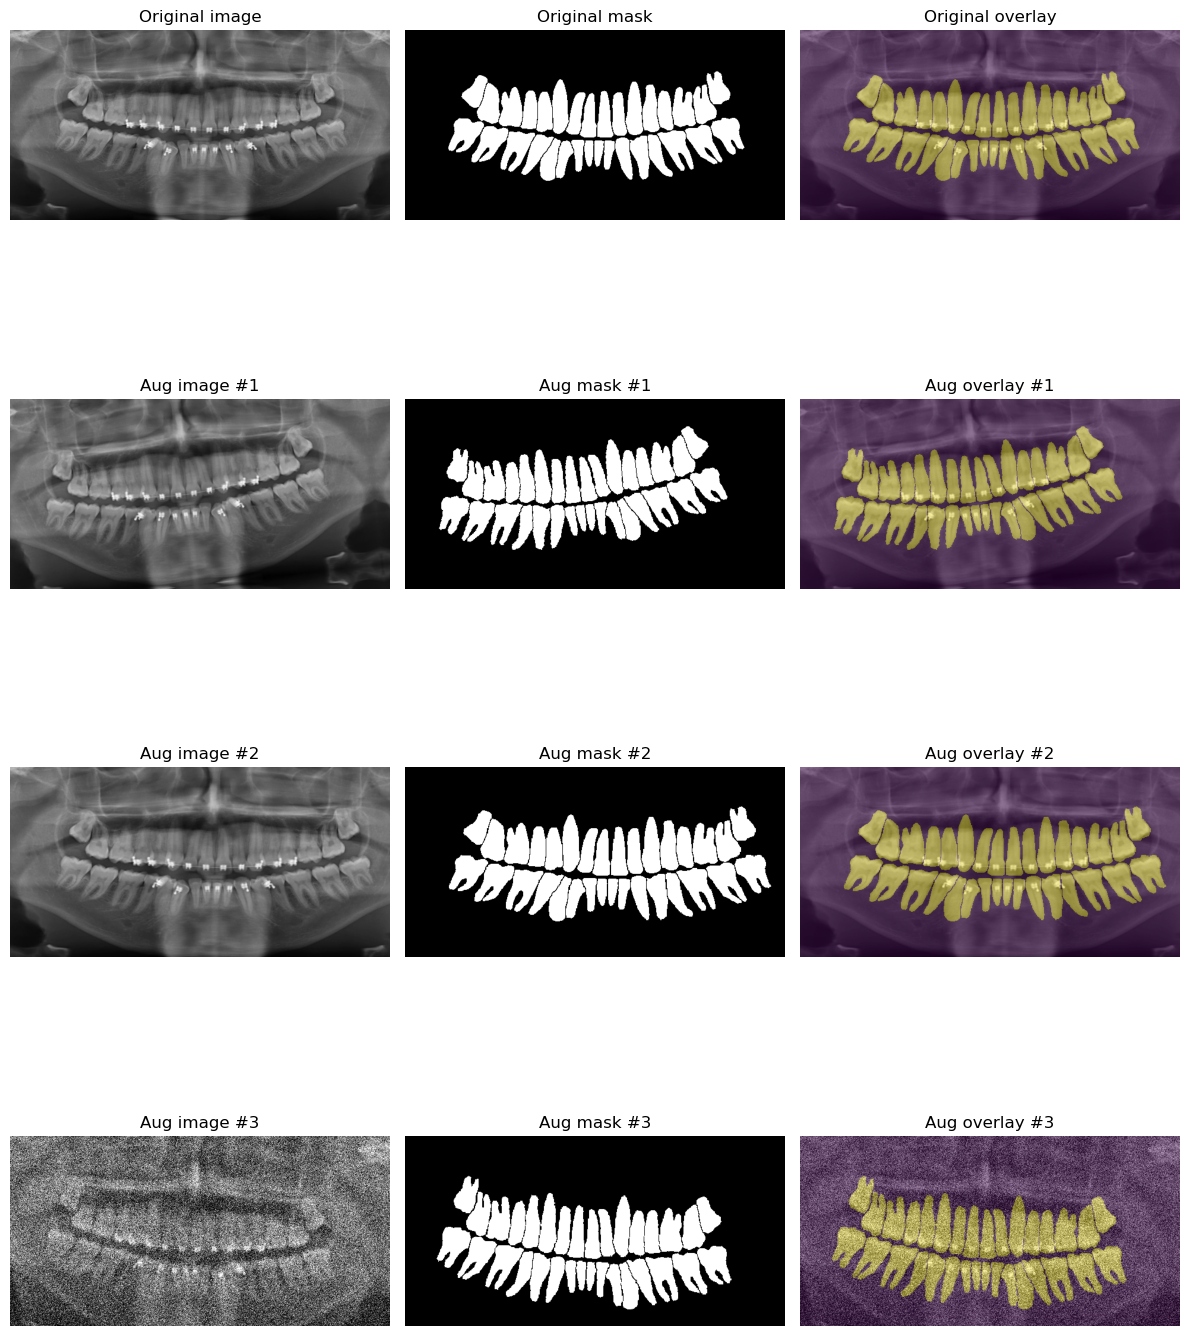


=== Example pair ===
Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_828.png
Mask path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\masks\A_L_828.png


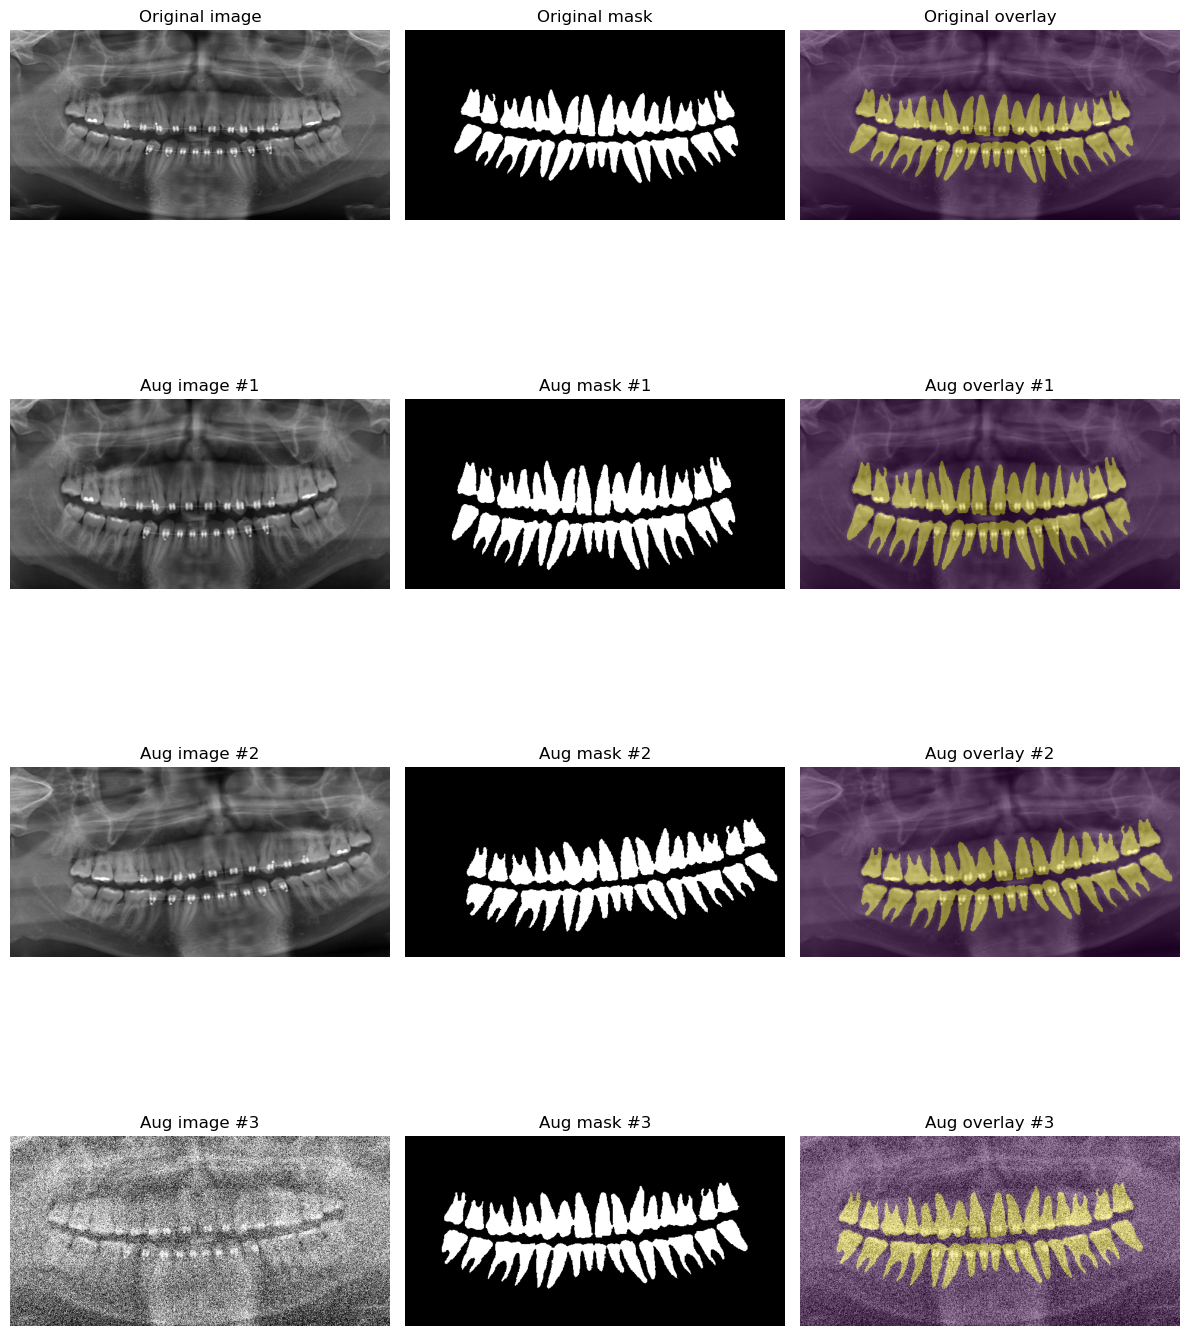

In [27]:
# Preview segmentation augmentations
seg_train_transform = get_segmentation_train_transform()

NUM_SAMPLES = 2      # how many different pairs to visualize
AUG_PER_SAMPLE = 3   # how many augmentations per pair

seg_rows = df_seg.sample(NUM_SAMPLES, random_state=SEED)

for idx, row in seg_rows.iterrows():
    img_path = get_image_path_from_row(row)
    mask_path = get_mask_path_from_row(row)

    img = load_image_as_array(img_path)
    mask = load_mask_as_array(mask_path)

    print("\n=== Example pair ===")
    print("Image path:", img_path)
    print("Mask path :", mask_path)

    fig, axes = plt.subplots(
        AUG_PER_SAMPLE + 1, 3, figsize=(12, 4 * (AUG_PER_SAMPLE + 1))
    )

    # First row: original
    axes[0, 0].imshow(img, cmap="gray")
    axes[0, 0].set_title("Original image")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(mask, cmap="gray")
    axes[0, 1].set_title("Original mask")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(img, cmap="gray")
    axes[0, 2].imshow(mask, alpha=0.4)
    axes[0, 2].set_title("Original overlay")
    axes[0, 2].axis("off")

    # Augmented rows
    for i in range(AUG_PER_SAMPLE):
        transformed = seg_train_transform(image=img, mask=mask)
        aug_img = transformed["image"].squeeze(0).cpu().numpy()  # shape: (H, W)
        aug_mask = transformed["mask"].cpu().numpy()

        r = i + 1
        axes[r, 0].imshow(aug_img, cmap="gray")
        axes[r, 0].set_title(f"Aug image #{i+1}")
        axes[r, 0].axis("off")

        axes[r, 1].imshow(aug_mask, cmap="gray")
        axes[r, 1].set_title(f"Aug mask #{i+1}")
        axes[r, 1].axis("off")

        axes[r, 2].imshow(aug_img, cmap="gray")
        axes[r, 2].imshow(aug_mask, alpha=0.4)
        axes[r, 2].set_title(f"Aug overlay #{i+1}")
        axes[r, 2].axis("off")

    plt.tight_layout()
    plt.show()


# %% [markdown]
# ## 5. Visualize pretraining (SSL) augmentations
# 
# For Stage 1 pretraining, we:
# 
# - Use **all** images in `df_pretrain` (both labeled and unlabeled, adult and children).
# - Ignore masks completely.
# - For each image, generate:
#   * one **weak** view (`ssl_weak_transform`)
#   * one **strong** view (`ssl_strong_transform`)
# 
# In this cell we visualize a few examples to check:
# 
# - Whether the two views clearly belong to the same underlying image.
# - Whether the strong augmentations are sufficiently different but still realistic.



D:\Tool\Anaconda3\envs\dlcv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



=== Pretrain sample ===
Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_556.png
age_group   : adult
label_status: labeled


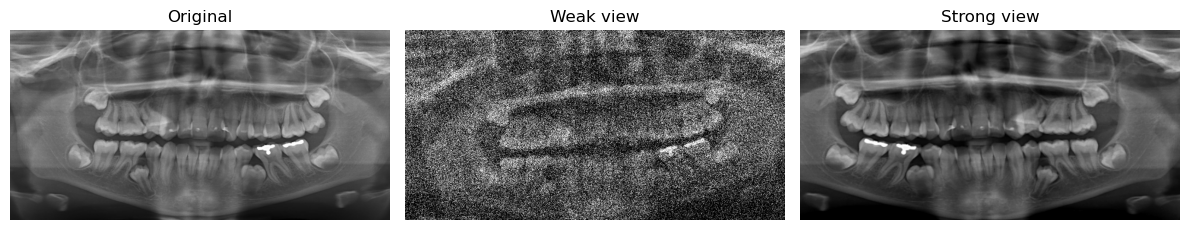


=== Pretrain sample ===
Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\unlabeled\images\A_U_2642.png
age_group   : adult
label_status: unlabeled


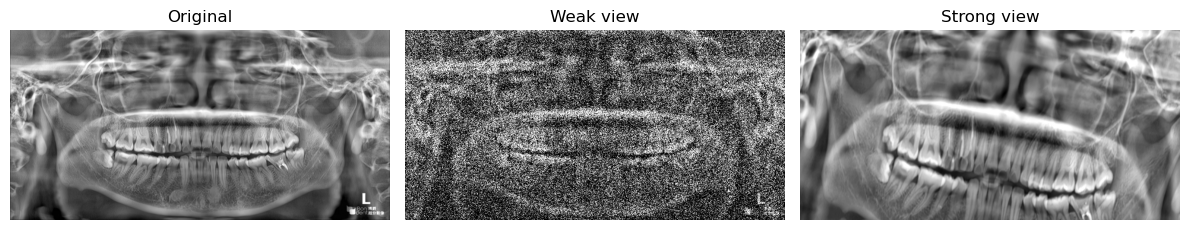


=== Pretrain sample ===
Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_528.png
age_group   : adult
label_status: labeled


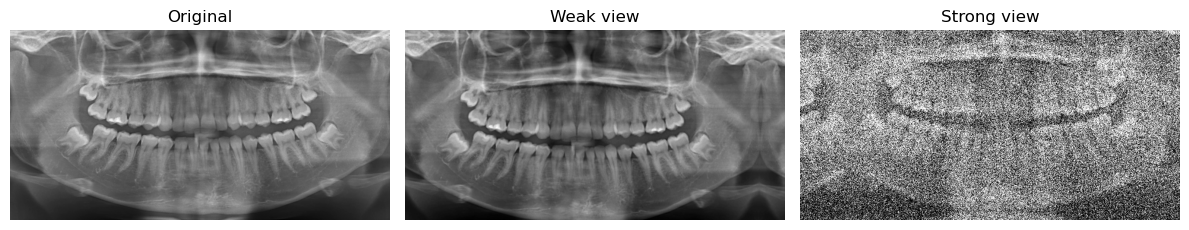


=== Pretrain sample ===
Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\children\unlabeled\images\C_U_376.png
age_group   : children
label_status: unlabeled


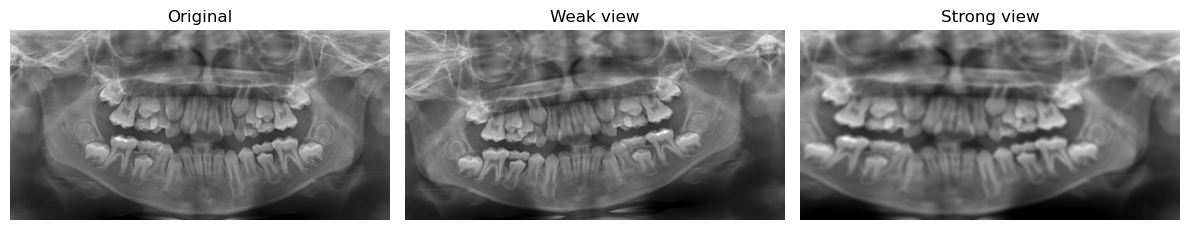

In [28]:
# Preview SSL weak + strong augmentations
ssl_weak_transform = get_ssl_weak_transform()
ssl_strong_transform = get_ssl_strong_transform()

NUM_PRETRAIN_SAMPLES = 4

pretrain_rows = df_pretrain.sample(NUM_PRETRAIN_SAMPLES, random_state=SEED)

for idx, row in pretrain_rows.iterrows():
    img_path = get_image_path_from_row(row)
    img = load_image_as_array(img_path)

    print("\n=== Pretrain sample ===")
    print("Image path:", img_path)
    print("age_group   :", row["age_group"])
    print("label_status:", row["label_status"])

    # Apply weak & strong augmentations
    out_weak = ssl_weak_transform(image=img)
    weak_img = out_weak["image"].squeeze(0).cpu().numpy()

    out_strong = ssl_strong_transform(image=img)
    strong_img = out_strong["image"].squeeze(0).cpu().numpy()

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(weak_img, cmap="gray")
    plt.title("Weak view")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(strong_img, cmap="gray")
    plt.title("Strong view")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [30]:
# Segmentation dataset

class DentalSegmentationDataset(Dataset):
    """
    PyTorch Dataset for supervised segmentation.

    Each item returns:
        image: FloatTensor (1, H, W)
        mask:  LongTensor (H, W)
        meta:  dict with auxiliary information
    """

    def __init__(self, df_seg: pd.DataFrame, transform: A.Compose):
        self.df = df_seg.reset_index(drop=True)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img_path = get_image_path_from_row(row)
        mask_path = get_mask_path_from_row(row)

        img = load_image_as_array(img_path)   # uint8, (H, W)
        mask = load_mask_as_array(mask_path)  # uint8/int, (H, W)

        # Albumentations expects dicts; we pass both image and mask.
        transformed = self.transform(image=img, mask=mask)
        img_t = transformed["image"]          # FloatTensor (1, H, W)
        mask_t = transformed["mask"]          # tensor (H, W) or (1, H, W)

        # Ensure mask is (H, W) LongTensor representing class indices
        if mask_t.ndim == 3:
            # shape (1, H, W) -> (H, W)
            mask_t = mask_t.squeeze(0)
        mask_t = mask_t.long()

        meta = {
            "img_path": str(img_path),
            "mask_path": str(mask_path),
            "pair_id": row["pair_id"],
            "age_group": row["age_group"],
            "label_status": row["label_status"],
        }

        return img_t, mask_t, meta


# Quick sanity check with a small DataLoader
seg_dataset = DentalSegmentationDataset(df_seg=df_seg, transform=seg_train_transform)
seg_loader = DataLoader(seg_dataset, batch_size=2, shuffle=True)

batch_images, batch_masks, batch_meta = next(iter(seg_loader))
print("Segmentation batch images shape:", batch_images.shape)  # (B, 1, H, W)
print("Segmentation batch masks shape :", batch_masks.shape)   # (B, H, W)

# batch_meta is a dict of lists (one list per key)
# Let's show the meta information for the first sample in the batch:
example_meta = {k: v[0] for k, v in batch_meta.items()}
print("Example meta (first sample):", example_meta)



# %% [markdown]
# ## 7. PyTorch Dataset for pretraining (Stage 1)
# 
# For Stage 1 pretraining, we want to:
# 
# - Use **all** images in `df_pretrain` (all non-mask rows).
# - For each image, generate **two** augmented views:
#   * `view1` (weak augmentation)  
#   * `view2` (strong augmentation)
# 
# We define `DentalPretrainDataset` that returns:
# 
# ```python
# img1, img2, meta = dataset[i]
# ```
# 
# where `img1` and `img2` are both `FloatTensor` of shape `(1, H, W)`.

Segmentation batch images shape: torch.Size([2, 1, 320, 640])
Segmentation batch masks shape : torch.Size([2, 320, 640])
Example meta (first sample): {'img_path': 'E:\\Data\\ToothSeg\\sts_tooth_data\\processed_2d\\adult\\labeled\\images\\A_L_695.png', 'mask_path': 'E:\\Data\\ToothSeg\\sts_tooth_data\\processed_2d\\adult\\labeled\\masks\\A_L_695.png', 'pair_id': 'a_l_695', 'age_group': 'adult', 'label_status': 'labeled'}


In [ ]:
# # %%
# # ============================================================
# # Cell 7 — Pretraining dataset (weak + strong views)
# # ============================================================
# 
# class DentalPretrainDataset(Dataset):
#     """
#     PyTorch Dataset for self-supervised / contrastive pretraining.
# 
#     Each item returns:
#         img_weak:   FloatTensor (1, H, W)
#         img_strong: FloatTensor (1, H, W)
#         meta:       dict with auxiliary information
#     """
# 
#     def __init__(
#         self,
#         df_pretrain: pd.DataFrame,
#         weak_transform: A.Compose,
#         strong_transform: A.Compose,
#     ):
#         self.df = df_pretrain.reset_index(drop=True)
#         self.weak_transform = weak_transform
#         self.strong_transform = strong_transform
# 
#     def __len__(self) -> int:
#         return len(self.df)
# 
#     def __getitem__(self, idx: int):
#         row = self.df.iloc[idx]
# 
#         img_path = get_image_path_from_row(row)
#         img = load_image_as_array(img_path)  # uint8, (H, W)
# 
#         # Apply weak and strong transforms separately
#         out_weak = self.weak_transform(image=img)
#         img_weak = out_weak["image"]   # FloatTensor (1, H, W)
# 
#         out_strong = self.strong_transform(image=img)
#         img_strong = out_strong["image"]  # FloatTensor (1, H, W)
# 
#         meta = {
#             "img_path": str(img_path),
#             "pair_id": row["pair_id"],
#             "age_group": row["age_group"],
#             "label_status": row["label_status"],
#         }
# 
#         return img_weak, img_strong, meta
# 
# 
# # Quick sanity check for pretraining dataset
# pretrain_dataset = DentalPretrainDataset(
#     df_pretrain=df_pretrain,
#     weak_transform=ssl_weak_transform,
#     strong_transform=ssl_strong_transform,
# )
# pretrain_loader = DataLoader(pretrain_dataset, batch_size=2, shuffle=True)
# 
# weak_batch, strong_batch, meta_batch = next(iter(pretrain_loader))
# print("Pretrain weak batch shape  :", weak_batch.shape)   # (B, 1, H, W)
# print("Pretrain strong batch shape:", strong_batch.shape) # (B, 1, H, W)
# print("Example meta:", meta_batch[0])


# %% [markdown]
# ## 8. Optional — Save augmented samples to disk
# 
# In most cases, it is better to apply augmentations **on the fly** during training.
# However, sometimes you may want to:
# 
# - Generate a small set of augmented samples for debugging.
# - Precompute a larger augmented dataset for experiments.
# 
# The following cell demonstrates how to:
# 
# - Iterate over the pretraining dataset.
# - For each original image, save `N` augmented weak/strong pairs to disk.
# 
# ⚠ **Warning:** Saving a full augmented dataset can consume a lot of disk space
# (e.g., 4000 images × multiple augmentations per image).

In [31]:
# %% [markdown]
# ## New Cell — Helper for MIM: online augmentation + patch masking
# 
# This cell defines:
# 
# - `patchify` / `unpatchify`: convert between images and patch sequences.
# - `DentalMIMDataset`: a PyTorch Dataset that, for each image:
#     1) loads the raw image,
#     2) applies a light augmentation (Albumentations),
#     3) splits it into patches,
#     4) randomly masks a subset of patches,
#     5) returns:
#         - `masked_patches`  (input to the MIM model)
#         - `mask`            (which patches were masked)
#         - `target_patches`  (ground truth patches to reconstruct)
#         - `meta`            (some metadata for debugging)

# %%
import math

def patchify(img_t: torch.Tensor, patch_size: int):
    """
    Convert an image tensor into a sequence of flattened patches.

    Args:
        img_t: FloatTensor of shape (C, H, W). In our case C=1.
        patch_size: size of square patches, e.g. 16.

    Returns:
        patches: FloatTensor of shape (num_patches, C * patch_size * patch_size)
        grid_hw: tuple (n_h, n_w) where:
                 n_h = number of patches along height
                 n_w = number of patches along width

    Note:
        We assume H and W are divisible by patch_size.
    """
    assert img_t.ndim == 3, f"Expected (C, H, W), got {img_t.shape}"
    C, H, W = img_t.shape
    assert H % patch_size == 0 and W % patch_size == 0, \
        f"H and W must be divisible by patch_size, got H={H}, W={W}, patch_size={patch_size}"

    n_h = H // patch_size
    n_w = W // patch_size

    # Add batch dimension: (1, C, H, W)
    img_t = img_t.unsqueeze(0)

    # Unfold into patches: shape (1, C, n_h, n_w, patch_size, patch_size)
    patches = img_t.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # Rearrange to (1, n_h, n_w, C, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()

    # Flatten each patch to a vector: (num_patches, C * patch_size * patch_size)
    patches = patches.view(n_h * n_w, C * patch_size * patch_size)

    return patches, (n_h, n_w)


def unpatchify(patches: torch.Tensor, grid_hw, patch_size: int, C: int = 1):
    """
    Reconstruct an image tensor from a sequence of flattened patches.

    This is mostly for debugging / visualization.

    Args:
        patches: FloatTensor of shape (num_patches, C * patch_size * patch_size)
        grid_hw: tuple (n_h, n_w)
        patch_size: patch size used in patchify
        C: number of channels (1 for grayscale)

    Returns:
        img_t: FloatTensor of shape (C, H, W)
    """
    n_h, n_w = grid_hw
    num_patches = n_h * n_w
    assert patches.shape[0] == num_patches, \
        f"Expected {num_patches} patches, got {patches.shape[0]}"

    # Reshape back to (1, n_h, n_w, C, patch_size, patch_size)
    patches = patches.view(1, n_h, n_w, C, patch_size, patch_size)

    # Rearrange to (1, C, n_h, patch_size, n_w, patch_size)
    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()

    # Merge patch dimensions back to H and W: (1, C, H, W)
    img = patches.view(1, C, n_h * patch_size, n_w * patch_size)

    # Remove batch dimension: (C, H, W)
    return img[0]


class DentalMIMDataset(Dataset):
    """
    PyTorch Dataset for Masked Image Modeling (MIM).

    For each item, it:
        1) loads a raw image from df_pretrain,
        2) applies a light augmentation transform (e.g. get_ssl_weak_transform()),
        3) splits the augmented image into flattened patches,
        4) randomly masks a subset of patches,
        5) returns:
            - masked_patches: FloatTensor (num_patches, patch_dim)
                              patches where masked positions are set to 0.
            - mask:           BoolTensor  (num_patches,)   True = masked
            - target_patches: FloatTensor (num_patches, patch_dim)
                              original patches before masking (for loss).
            - meta:           dict with metadata.
    """

    def __init__(
        self,
        df_pretrain: pd.DataFrame,
        transform: A.Compose,
        patch_size: int = 16,
        mask_ratio: float = 0.6,
    ):
        """
        Args:
            df_pretrain: DataFrame containing non-mask images (like df_pretrain in Cell 1).
            transform: Albumentations transform for light augmentation + normalization.
                       For example: get_ssl_weak_transform().
            patch_size: size of square patches in pixels (e.g. 16).
            mask_ratio: fraction of patches to mask (0.0 ~ 1.0), e.g. 0.6.
        """
        self.df = df_pretrain.reset_index(drop=True)
        self.transform = transform
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        # 1) Load grayscale image as uint8 array (H, W)
        img_path = get_image_path_from_row(row)
        img = load_image_as_array(img_path)

        # 2) Apply augmentation + normalization
        #    transform should output a dict with key "image" as a FloatTensor (C, H, W)
        transformed = self.transform(image=img)
        img_t = transformed["image"]          # FloatTensor, shape (1, H, W)
        C, H, W = img_t.shape

        # 3) Split into flattened patches
        patches, grid_hw = patchify(img_t, self.patch_size)   # (num_patches, patch_dim)
        num_patches, patch_dim = patches.shape

        # 4) Generate a random binary mask over patches
        num_mask = int(self.mask_ratio * num_patches)
        # mask: BoolTensor, True means "this patch is masked"
        mask = torch.zeros(num_patches, dtype=torch.bool)
        perm = torch.randperm(num_patches)
        mask[perm[:num_mask]] = True

        # 5) Create masked patches (input) and target patches (for loss)
        target_patches = patches.clone()                  # ground truth
        masked_patches = patches.clone()
        masked_patches[mask] = 0.0                        # here we simply zero out masked patches

        meta = {
            "img_path": str(img_path),
            "pair_id": row["pair_id"],
            "age_group": row["age_group"],
            "label_status": row["label_status"],
            "grid_hw": grid_hw,           # (n_h, n_w) for potential unpatchify/visualization
            "H": H,
            "W": W,
        }

        return masked_patches, mask, target_patches, meta

In [32]:
# %%  (Sanity check for DentalMIMDataset)

# Use the weak SSL transform as the light pre-augmentation for MIM
mim_transform = get_ssl_weak_transform()

mim_dataset = DentalMIMDataset(
    df_pretrain=df_pretrain,
    transform=mim_transform,
    patch_size=16,
    mask_ratio=0.6,
)

print("Number of MIM samples:", len(mim_dataset))

masked_patches, mask_vec, target_patches, meta = mim_dataset[0]
print("masked_patches shape :", masked_patches.shape)   # (num_patches, patch_dim)
print("mask_vec shape       :", mask_vec.shape)         # (num_patches,)
print("target_patches shape :", target_patches.shape)   # (num_patches,)
print("Example meta         :", meta)


Number of MIM samples: 4000
masked_patches shape : torch.Size([800, 256])
mask_vec shape       : torch.Size([800])
target_patches shape : torch.Size([800, 256])
Example meta         : {'img_path': 'E:\\Data\\ToothSeg\\sts_tooth_data\\processed_2d\\adult\\labeled\\images\\A_L_001.png', 'pair_id': 'a_l_001', 'age_group': 'adult', 'label_status': 'labeled', 'grid_hw': (20, 40), 'H': 320, 'W': 640}


D:\Tool\Anaconda3\envs\dlcv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
